# CS235 Fall 2025 Course Project

Name: William Nguyen

Student ID: 862549100

## Introduction
In this project, a number of data mining techniques that we cover in this class will be implemented and applied to a real-world imbalanced
dataset.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

## Setup

1. Create new python environment for the project

- This is not necessary on Google Colab but a good practice on your local machine

2. Install the required packages

In [53]:
!pip install ucimlrepo

## Imports

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import itertools, collections
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [55]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

X.head()

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [56]:
# Encoded M and B into 0 and 1 for model training
y = y.replace({"M": 0, "B": 1})
y.value_counts()

Diagnosis
1            357
0            212
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

### Pairwise correlation between features

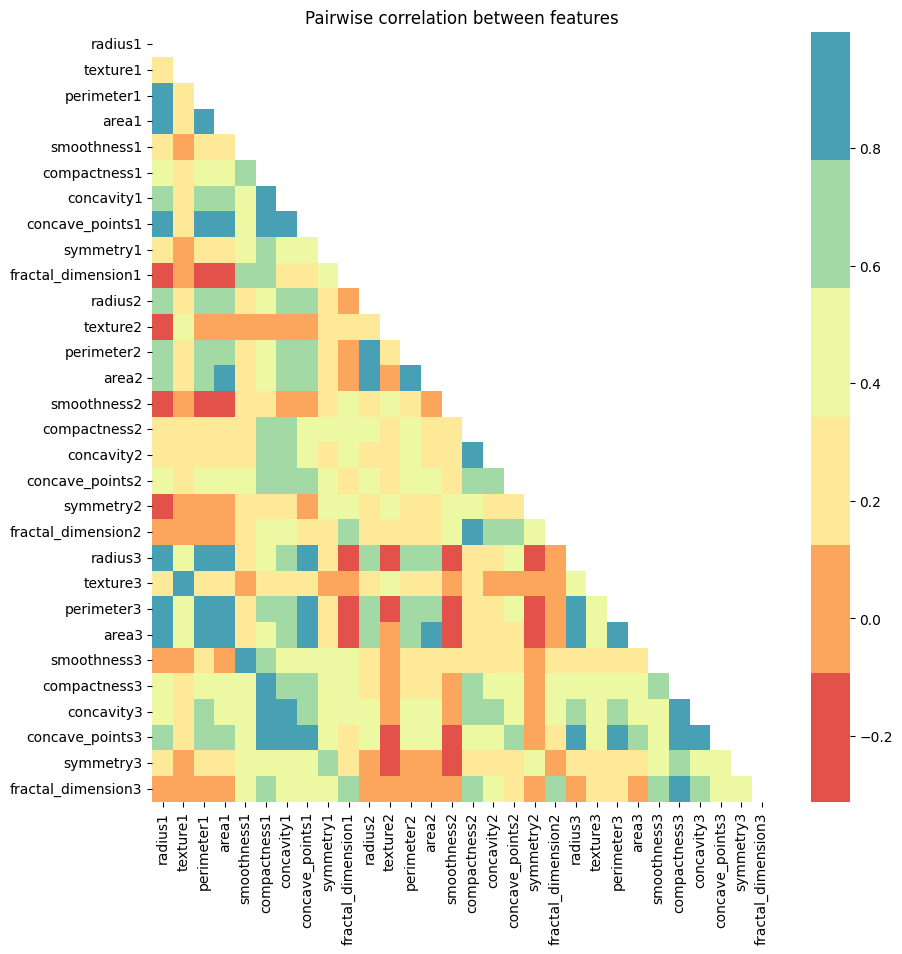

In [57]:
correlation = X.corr()

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(correlation, annot=False, mask=np.triu(correlation),
            cmap=sns.color_palette("Spectral"))
ax.set_title("Pairwise correlation between features")
plt.show()

### Class Counts

In [58]:
print(collections.Counter(y['Diagnosis']))

Counter({1: 357, 0: 212})


### Class-wise features distributions

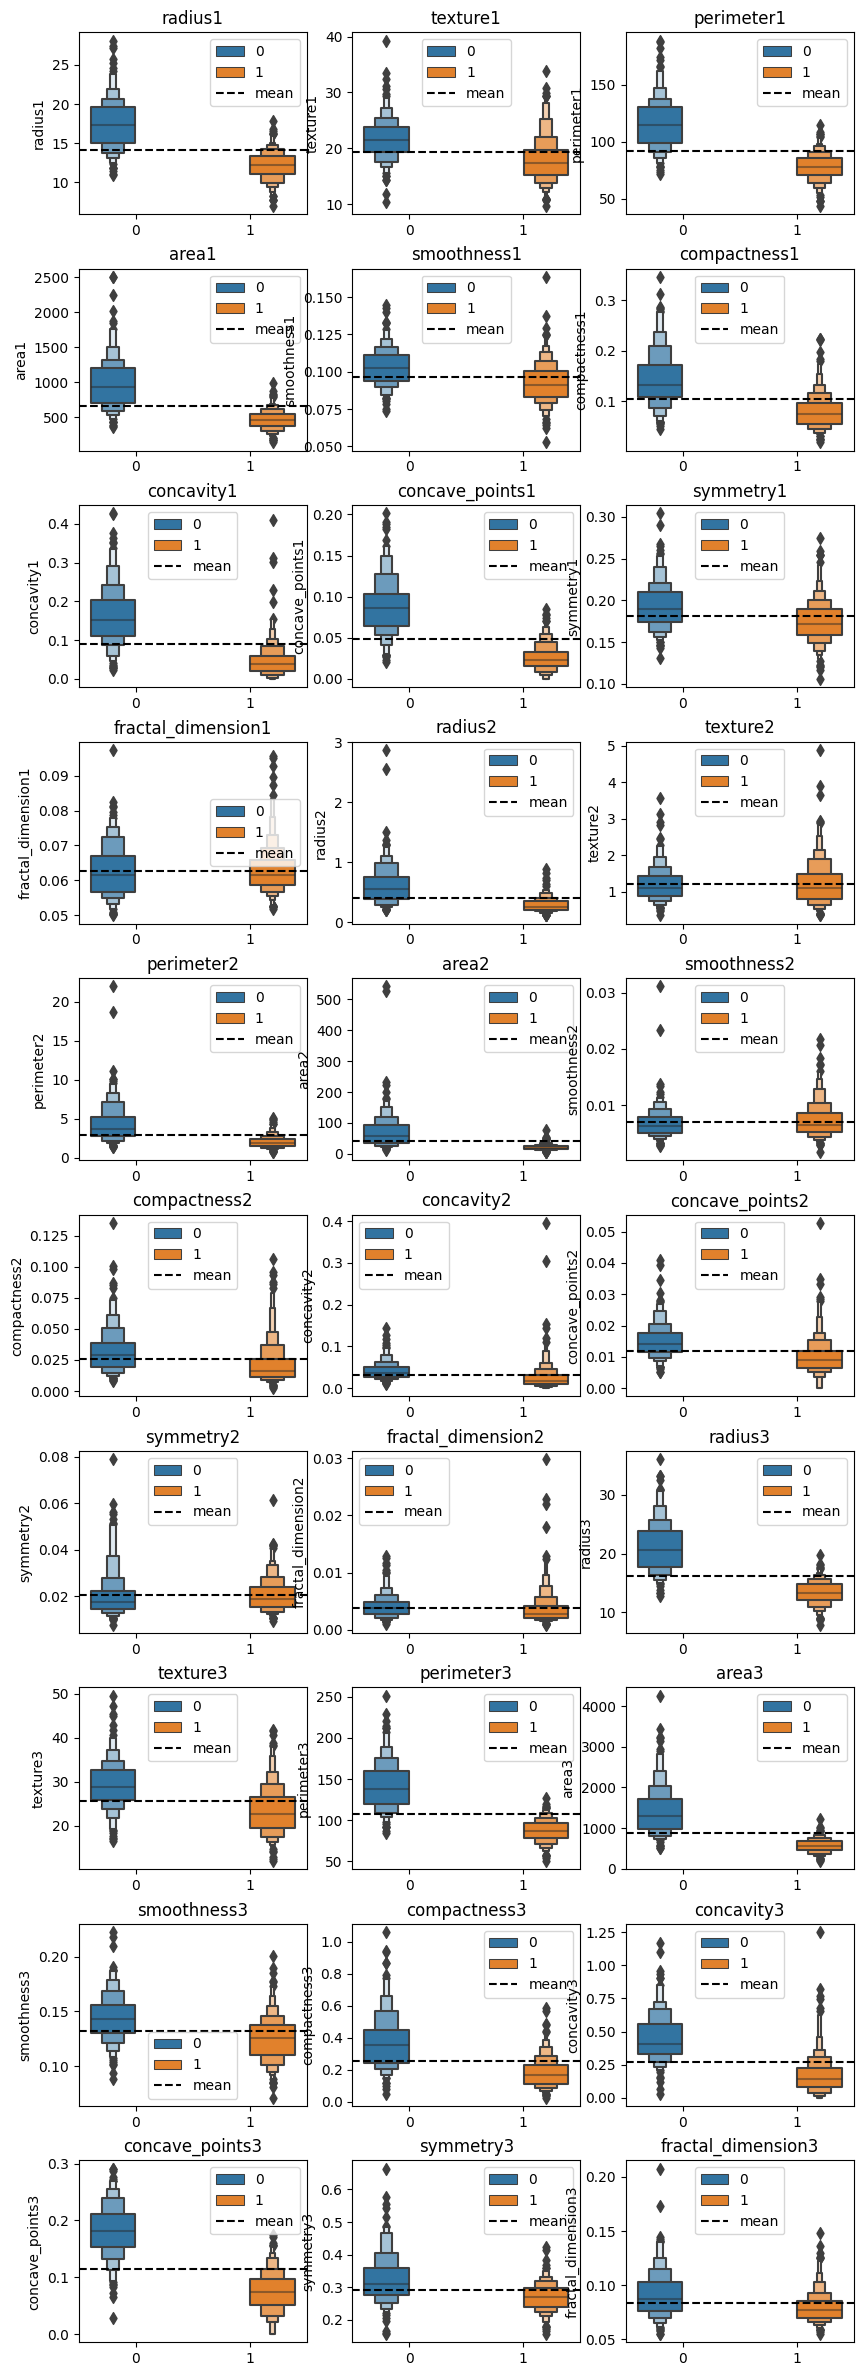

In [59]:
plt.figure(figsize=(10,30))

for i,j in itertools.zip_longest(list(X.columns), range(len(list(X.columns)))):
  plt.subplot(10,3,j+1)
  sns.boxenplot(x=y['Diagnosis'], y=X[i], hue=y['Diagnosis'])
  plt.title(i)
  plt.xlabel('')
  plt.subplots_adjust(hspace=.3)
  plt.axhline(X[i].mean(), linestyle="dashed", color='k', label='mean')
  plt.legend(loc='best')

# Phase 1 - Supervised Techniques

## Q1 - Implementing simple classifiers

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

In [60]:
# Data Splitting
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # split 10 times and shuffle

In [61]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV # StratifiedKfold is essentially K-fold CV for classification datasets where the target variable is imbalanced
from sklearn.metrics import classification_report, f1_score

dtc = DecisionTreeClassifier()

space = {
    "criterion": ["gini", "entropy"], # information gain criteria
    "max_depth": np.linspace(1, 10, 10, dtype=int), # controls the max depth of trees (deeper trees, more complex [lower bias, higher variance])
    "min_samples_split": np.linspace(2, 40, 20, dtype=int), # minimum number of samples per split (higer min splits leads to higher bias, lower variance)
}

dtc_grid = GridSearchCV(dtc, param_grid=space, scoring="f1", cv=skf, verbose=1, error_score="raise")
dtc_grid.fit(X_train, y_train)

dtc_pred = dtc_grid.predict(X_test)

dtc_f1_scores = cross_val_score(
    estimator=dtc_grid.best_estimator_, # used the best model
    X=X,
    y=y,
    cv=skf,
    scoring="f1"
)

print(classification_report(y_test, dtc_pred))
print(f"Best Parameters: {dtc_grid.best_params_}")
print(f"Mean F1 Score: {dtc_f1_scores.mean():.2f}")
print(f"STD F1 Score: {dtc_f1_scores.std():.2f}")


Fitting 10 folds for each of 400 candidates, totalling 4000 fits
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       0.96      0.94      0.95        72

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4}
Mean F1 Score: 0.94
STD F1 Score: 0.02


In [62]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

space = {
    "priors": [None, [0.6, 0.4], [0.7, 0.3]], # represents prior beliefs of each class, for example, 0.6,0.4 meand 60% belong to class 0, 40% belongs to class 1
    "var_smoothing": np.logspace(-10,-1,100) # used to increase smoothing, making model less sensitive to outliers in the training data
}

gnb_grid = GridSearchCV(gnb, cv=skf, scoring='f1', verbose=1, param_grid=space, error_score="raise") # initialize GridSearchCV
gnb_grid.fit(X_train, y_train)

gnb_pred = gnb_grid.predict(X_test)

gnb_f1_scores = cross_val_score(
    estimator=gnb_grid.best_estimator_, # used the best model
    X=X,
    y=y,
    cv=skf,
    scoring="f1"
)

print(classification_report(y_test, gnb_pred))
print(f"Best Parameters: {gnb_grid.best_params_}")
print(f"Mean F1 Score: {gnb_f1_scores.mean():.2f}") # high f1 scores indicates model is good a predicting both classes few missclassifications (FN and FP)
print(f"STD F1 Score: {gnb_f1_scores.std():.2f}") # represents variance in each fold

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.94      0.94      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114

Best Parameters: {'priors': [0.7, 0.3], 'var_smoothing': 1.873817422860387e-09}
Mean F1 Score: 0.95
STD F1 Score: 0.02


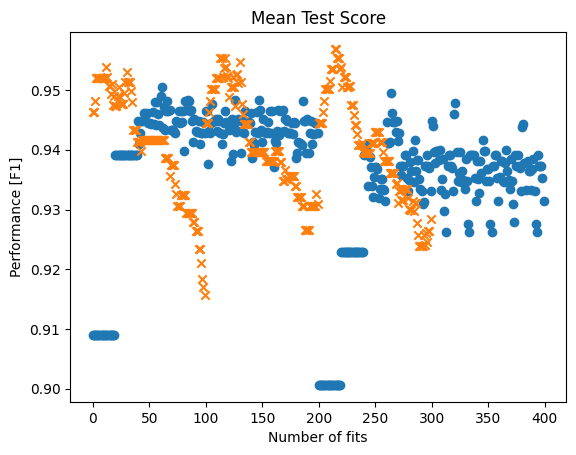

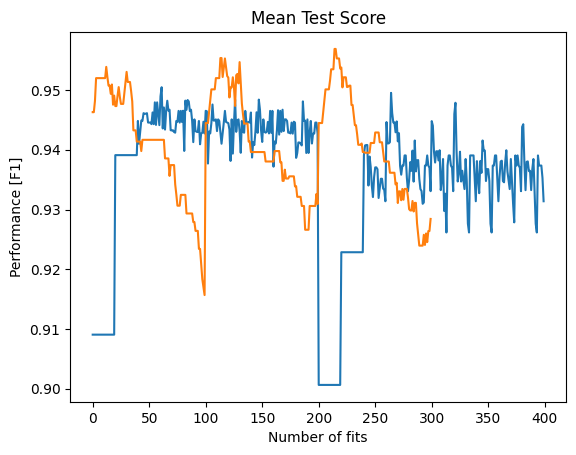

In [63]:
# Performance Comparison

# Mean Test Scores
dtc_scores = dtc_grid.cv_results_["mean_test_score"]
gnb_scores = gnb_grid.cv_results_["mean_test_score"]

# Scatter Plot
plt.scatter(range(len(dtc_scores)), dtc_grid.cv_results_["mean_test_score"], marker="o")
plt.scatter(range(len(gnb_scores)), gnb_grid.cv_results_["mean_test_score"], marker="x")
plt.title("Mean Test Score")
plt.xlabel("Number of fits")
plt.ylabel("Performance [F1]")
plt.show()

# Line Plot
plt.plot(dtc_grid.cv_results_["mean_test_score"])
plt.plot(gnb_grid.cv_results_["mean_test_score"])
plt.title("Mean Test Score")
plt.xlabel("Number of fits")
plt.ylabel("Performance [F1]")
plt.show()

# Plot show both models performance when compared to each other
# GaussianNB seems to have higher performance peaks in less overall fits then Decision Tree Classifier
# Even though GNB has higher peaks, its accuracy is actually 1 percent lower that DTC. This could be due to the difference in number of fits (4000 fits vs. 3000 fits, DTC has 25% more fits than GNB) 
# When looking at the total F1 scores for both models, both tend to perform a 3-4 scores better when predictions class 1 over class 0

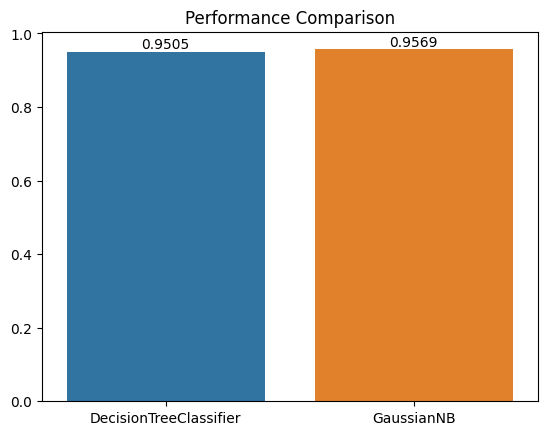

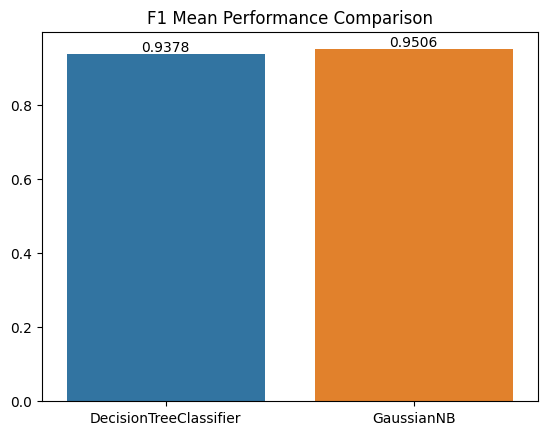

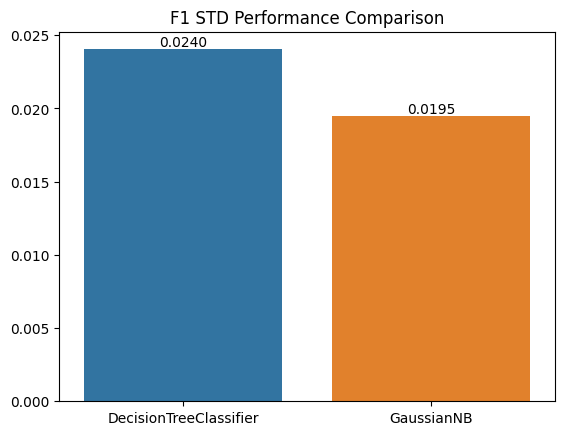

In [64]:
# Performance Comparison

# Best score performance comparison
performance_df = ({
    "Model": ["DecisionTreeClassifier", "GaussianNB"],
    "Performance": [dtc_grid.best_score_, gnb_grid.best_score_]
})

ax = sns.barplot(data=performance_df, x="Model", y="Performance")

for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", label_type="edge")

plt.title("Performance Comparison")
plt.show()


# Mean F1 score comparison
f1_mean_comparision_df = ({
    "Model": ["DecisionTreeClassifier", "GaussianNB"],
    "Performance": [dtc_f1_scores.mean(), gnb_f1_scores.mean()]
})

ax = sns.barplot(data=f1_mean_comparision_df, x="Model", y="Performance")

for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", label_type="edge")

plt.title("F1 Mean Performance Comparison")
plt.show()


# STD F1 score comparison
f1_std_comparision_df = ({
    "Model": ["DecisionTreeClassifier", "GaussianNB"],
    "Performance": [dtc_f1_scores.std(), gnb_f1_scores.std()]
})

ax = sns.barplot(data=f1_std_comparision_df, x="Model", y="Performance")

for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", label_type="edge")

plt.title("F1 STD Performance Comparison")
plt.show()


## Q2 - Dimensionality reduction with the Singular Value Decomposition

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# standarize to make all features have similar scales 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#set component range from 2-30 to test all the components 
n_components_list = range(2, 31)
svd_results = []

# loop through each component count to evaluate performance
for n_comp in n_components_list:
    # apply SVD 
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    X_train_svd = svd.fit_transform(X_train_scaled)
    X_test_svd = svd.transform(X_test_scaled)
    
    # train Decision Tree on the reduced dataset
    dtc = DecisionTreeClassifier()  
    dtc_space = {
        "criterion": ["gini", "entropy"], # using the same hyperparameter for consistency
        "max_depth": np.linspace(1, 10, 10, dtype=int),
        "min_samples_split": np.linspace(2, 40, 20, dtype=int),
    }
    dtc_grid = GridSearchCV(dtc, param_grid=dtc_space, scoring="f1", cv=skf, verbose=0)
    dtc_grid.fit(X_train_svd, y_train)
    
    # train GNB on the reduced dataset
    gnb = GaussianNB()
    gnb_space = { 
        "priors": [None, [0.6, 0.4], [0.7, 0.3]],  # using the same hyperparameter for consistency
        "var_smoothing": np.logspace(-10,-1,100)
    }
    gnb_grid = GridSearchCV(gnb, cv=skf, scoring='f1', verbose=0, param_grid=gnb_space)
    gnb_grid.fit(X_train_svd, y_train)
    
    # store the results for this component count
    svd_results.append({
        'n_components': n_comp,
        'explained_variance': svd.explained_variance_ratio_.sum(), # track explained variance to see how much information we're keeping
        'dtc_score': dtc_grid.best_score_,
        'gnb_score': gnb_grid.best_score_
    })

# convert to DF
svd_df = pd.DataFrame(svd_results)

#best performance for each model
print(f"Best DTC: {svd_df['dtc_score'].max():.4f} at {svd_df.loc[svd_df['dtc_score'].idxmax(), 'n_components']} components")
print(f"Best GNB: {svd_df['gnb_score'].max():.4f} at {svd_df.loc[svd_df['gnb_score'].idxmax(), 'n_components']} components")

In [ ]:
#1 Explained variance plot
plt.figure(figsize=(7, 5))
plt.plot(svd_df['n_components'], svd_df['explained_variance'], marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Components')
plt.grid(True)
plt.show()

#2 Model Performance vs Components
plt.figure(figsize=(7, 5))
plt.plot(svd_df['n_components'], svd_df['dtc_score'], marker='o', label='Decision Tree')
plt.plot(svd_df['n_components'], svd_df['gnb_score'], marker='s', label='Gaussian NB')
plt.xlabel('Number of Components')
plt.ylabel('F1 Score')
plt.title('Model Performance vs Components')
plt.legend()
plt.grid(True)
plt.show()

## Q3 - Feature selection with randomization

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# train a Random Forest 
rf = RandomForestClassifier(n_estimators=100, random_state=42) #100 different decision trees
rf.fit(X_train, y_train.values.ravel()) #ravel() to make y_train into the right shape

# calculate permutation importance
perm_importance = permutation_importance(rf, X_test, y_test.values.ravel(), 
                                         n_repeats=10, random_state=42, scoring='f1') #shuffled 10 times then later evaluate the mean

# organize into DF then rank via feature importance 
feature_importance_df = pd.DataFrame({
    'feature': X.columns, #feature names
    'importance': perm_importance.importances_mean #get the average
}).sort_values('importance', ascending=False) #sort via most important to least


feature_results = []

for n_features in range(1, 31): #test all features
    # select only the top n most important features
    top_features = feature_importance_df.head(n_features)['feature'].values
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]
    
    # train Decision Tree with selected features only
    dtc = DecisionTreeClassifier()
    dtc_space = {
        "criterion": ["gini", "entropy"], # using the same hyperparameter for consistency
        "max_depth": np.linspace(1, 10, 10, dtype=int),
        "min_samples_split": np.linspace(2, 40, 20, dtype=int),
    }
    dtc_grid = GridSearchCV(dtc, param_grid=dtc_space, scoring="f1", cv=skf, verbose=0)
    dtc_grid.fit(X_train_selected, y_train)
    
    # train GNB with selected features only
    gnb = GaussianNB()
    gnb_space = {
        "priors": [None, [0.6, 0.4], [0.7, 0.3]], # using the same hyperparameter for consistency
        "var_smoothing": np.logspace(-10,-1,100)
    }
    gnb_grid = GridSearchCV(gnb, cv=skf, scoring='f1', verbose=0, param_grid=gnb_space)
    gnb_grid.fit(X_train_selected, y_train)
    
    # store results for this feature 
    feature_results.append({
        'n_features': n_features,
        'dtc_score': dtc_grid.best_score_,
        'gnb_score': gnb_grid.best_score_
    })

# convert to DF
feature_df = pd.DataFrame(feature_results)

# best performance for each model
print(f"Best DTC: {feature_df['dtc_score'].max():.4f} with {feature_df.loc[feature_df['dtc_score'].idxmax(), 'n_features']} features")
print(f"Best GNB: {feature_df['gnb_score'].max():.4f} with {feature_df.loc[feature_df['gnb_score'].idxmax(), 'n_features']} features")
print("\nTop 10 features:")
print(feature_importance_df.head(10))

In [ ]:
#1 Top 10 most important features 
plt.figure(figsize=(7, 5))
plt.barh(range(10), feature_importance_df.head(10)['importance'])
plt.yticks(range(10), feature_importance_df.head(10)['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Put highest importance at the top
plt.show()

# 2 Model performance vs # of features
plt.figure(figsize=(7, 5))
plt.plot(feature_df['n_features'], feature_df['dtc_score'], marker='o', label='Decision Tree')
plt.plot(feature_df['n_features'], feature_df['gnb_score'], marker='s', label='Gaussian NB')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('Model Performance vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()

## Q4 - Data augmentation using SMOTE

In [69]:
# [YOUR IMPLEMENTATION CODE HERE]
from imblearn.over_sampling import SMOTE # used to apply SMOTE
from collections import Counter # used to check class distribution



# Check class distribution before applying SMOTE
print(Counter(y_train["Diagnosis"]))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) # apply SMOTE onto training data

# Check class distribution after applying SMOTE
print(Counter(y_train_smote["Diagnosis"]))

Counter({1: 285, 0: 170})
Counter({1: 285, 0: 285})


In [70]:
# Retrain models with new training data

# Re-apply StratifiedKfold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # split 10 times and shuffle


# Decision Tree Classifier
dtc = DecisionTreeClassifier()

space = {
    "criterion": ["gini", "entropy"], # information gain criteria
    "max_depth": np.linspace(1, 10, 10, dtype=int), # controls the max depth of trees (deeper trees, more complex [lower bias, higher variance])
    "min_samples_split": np.linspace(2, 40, 20, dtype=int), # minimum number of samples per split (higer min splits leads to higher bias, lower variance)
}

dtc_grid = GridSearchCV(dtc, param_grid=space, scoring="f1", cv=skf, verbose=1, error_score="raise")
dtc_grid.fit(X_train_smote, y_train_smote) # new SMOTE training data

dtc_pred = dtc_grid.predict(X_test)

dtc_f1_scores = cross_val_score(
    estimator=dtc_grid.best_estimator_, # used the best model
    X=X,
    y=y,
    cv=skf,
    scoring="f1"
)

print(classification_report(y_test, dtc_pred))
print(f"Best Parameters: {dtc_grid.best_params_}")
print(f"Mean F1 Score: {dtc_f1_scores.mean():.2f}")
print(f"STD F1 Score: {dtc_f1_scores.std():.2f}")


# Gaussian Naive Bayes
gnb = GaussianNB()

space = {
    "priors": [None, [0.6, 0.4], [0.7, 0.3]], # represents prior beliefs of each class, for example, 0.6,0.4 meand 60% belong to class 0, 40% belongs to class 1
    "var_smoothing": np.logspace(-10,-1,100) # used to increase smoothing, making model less sensitive to outliers in the training data
}

gnb_grid = GridSearchCV(gnb, cv=skf, scoring='f1', verbose=1, param_grid=space, error_score="raise") # initialize GridSearchCV
gnb_grid.fit(X_train_smote, y_train_smote) # use SMOTE training data

gnb_pred = gnb_grid.predict(X_test)

gnb_f1_scores = cross_val_score(
    estimator=gnb_grid.best_estimator_, # used the best model
    X=X,
    y=y,
    cv=skf,
    scoring="f1"
)

print(classification_report(y_test, gnb_pred))
print(f"Best Parameters: {gnb_grid.best_params_}")
print(f"Mean F1 Score: {gnb_f1_scores.mean():.2f}") # high f1 scores indicates model is good a predicting both classes few missclassifications (FN and FP)
print(f"STD F1 Score: {gnb_f1_scores.std():.2f}") # represents variance in each fold

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        42
           1       0.94      0.89      0.91        72

    accuracy                           0.89       114
   macro avg       0.88      0.90      0.89       114
weighted avg       0.90      0.89      0.90       114

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}
Mean F1 Score: 0.94
STD F1 Score: 0.03
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.94      0.94      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114

Best Parameters: {'priors': [0.7, 0.3], 'var_smoothing': 1.873817422860387e-09}
Mean F1 Score: 

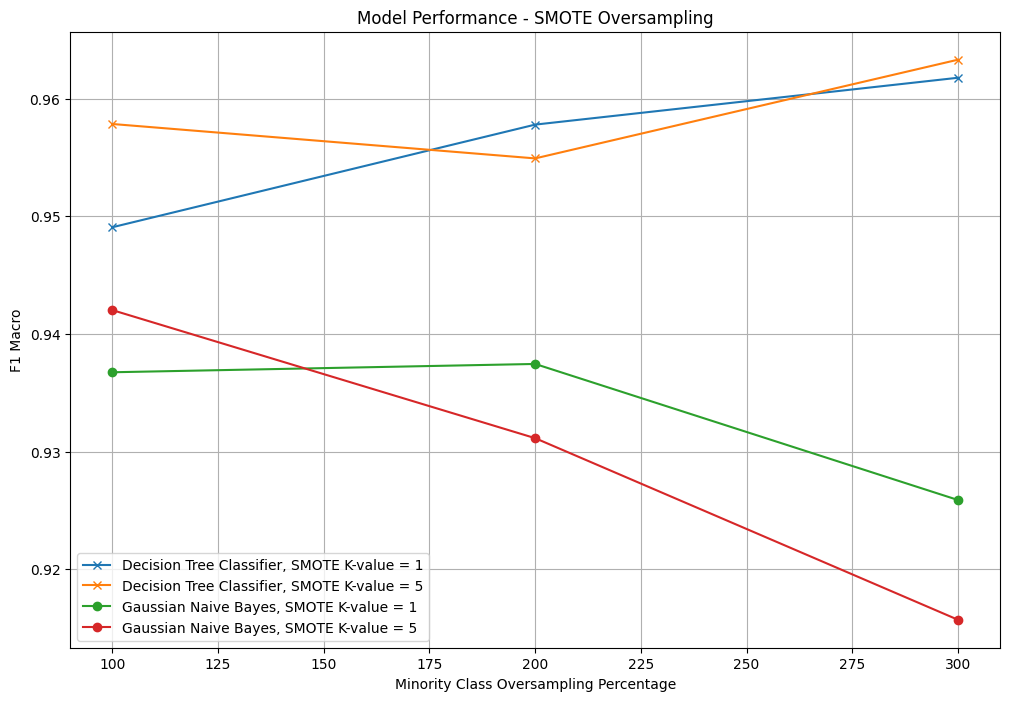

In [ ]:
# Performance Plot

y_train_series = y_train["Diagnosis"] # set y_train as a 1 Dimensional series b/c SMOTE only takes 1D series as an input

# Apply StratifiedKfold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # split 10 times and shuffle

# Set oversampling and smote k-values
oversample_percentages = [1.0, 2.0, 3.0] # 100%, 200%, 300%
k_values_smote = [1, 5] # k-values for smote (k-number of neighbors SMOTE accounts for)

# Set classes
classifiers = {
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB()
}

# Obtain counts per class using counter
counts = Counter(y_train_series)

# Store model outputs in a dictionary 
output = {model_name: {value: [] for value in k_values_smote} for model_name in classifiers.keys()}


# Loop
# For each model, for each k-value, and for each oversampling percentage...
    # 1. Calculate the target count: majority class * oversampling percentage [1.0, 2.0, or 3.0]]
    # 2. Train SMOTE based on that oversampling percentage, and set k = to 1 or 5 based on loop
    # 3. Evaluate using cross_value_score and save performance to output dictionary

for model_name, classifier in classifiers.items():
    for value in k_values_smote:
        for p in oversample_percentages:

            t_count = int(counts[max(counts, key=counts.get)] * p)
            smote = SMOTE(sampling_strategy={min(counts, key=counts.get): t_count}, k_neighbors=value, random_state=42)


            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_series) 

            scores = cross_val_score(classifier, X_train_smote, y_train_smote, cv=skf, scoring="f1_macro")
            output[model_name][value].append(np.mean(scores))

# Plot Performance
x_values = [p * 100 for p in oversample_percentages] # calculates 100%, 200%, 300% (used for x-axis)

plt.figure(figsize=(12,8))

# Plot each combination of k-values with each model (2 models * 2 k-values = 4 plots)
plt.plot(x_values, output["Decision Tree Classifier"][1], marker="x", label = "Decision Tree Classifier, SMOTE K-value = 1")
plt.plot(x_values, output["Decision Tree Classifier"][5], marker="x", label = "Decision Tree Classifier, SMOTE K-value = 5")

plt.plot(x_values, output["GaussianNB"][1], marker="o", label = "Gaussian Naive Bayes, SMOTE K-value = 1")
plt.plot(x_values, output["GaussianNB"][5], marker="o", label = "Gaussian Naive Bayes, SMOTE K-value = 5")

plt.title("Model Performance - SMOTE Oversampling")
plt.xlabel("Minority Class Oversampling Percentage")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid()
plt.show()

# Sources

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html